In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
path = 'dataset_mitdb/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [3]:
# Membaca file dataset melalui path di atas
filenames = next(os.walk(path))[2]

# Variabel membagi jenis extension file
records = list()
annotations = list()
filenames.sort()

filenames

['100.csv',
 '100annotations.txt',
 '101.csv',
 '101annotations.txt',
 '102.csv',
 '102annotations.txt',
 '103.csv',
 '103annotations.txt',
 '104.csv',
 '104annotations.txt',
 '105.csv',
 '105annotations.txt',
 '106.csv',
 '106annotations.txt',
 '107.csv',
 '107annotations.txt',
 '108.csv',
 '108annotations.txt',
 '109.csv',
 '109annotations.txt',
 '111.csv',
 '111annotations.txt',
 '112.csv',
 '112annotations.txt',
 '113.csv',
 '113annotations.txt',
 '114.csv',
 '114annotations.txt',
 '115.csv',
 '115annotations.txt',
 '116.csv',
 '116annotations.txt',
 '117.csv',
 '117annotations.txt',
 '118.csv',
 '118annotations.txt',
 '119.csv',
 '119annotations.txt',
 '121.csv',
 '121annotations.txt',
 '122.csv',
 '122annotations.txt',
 '123.csv',
 '123annotations.txt',
 '124.csv',
 '124annotations.txt',
 '200.csv',
 '200annotations.txt',
 '201.csv',
 '201annotations.txt',
 '202.csv',
 '202annotations.txt',
 '203.csv',
 '203annotations.txt',
 '205.csv',
 '205annotations.txt',
 '207.csv',
 '207ann

In [4]:
# Memisahkan file dengan extension masing - masing kedalam variable
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [5]:
# Melakukan denoising atau mengurangi bentuk signal yang distorsi
def denoise(df): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(df), w.dec_len)
    threshold = 0.04 # Nilai filtering

    coeffs = pywt.wavedec(df, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

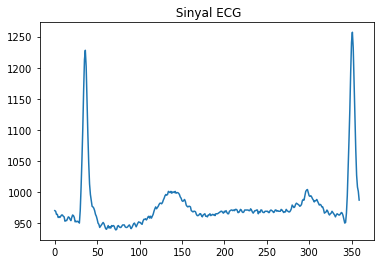

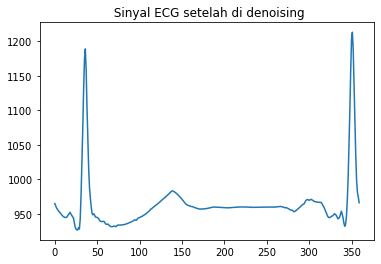

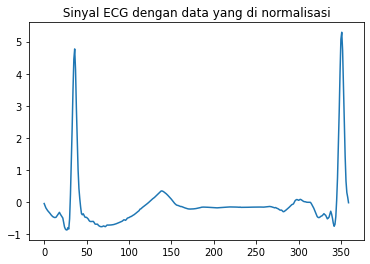

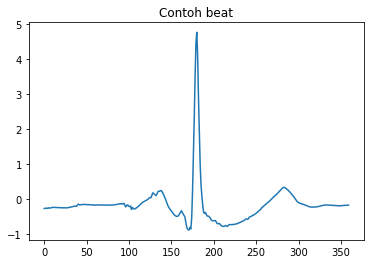

In [17]:
# Mengolah dan membaca isi file yang terdapat pada dataset
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot contoh sinyal ecg dengan index ke 0
    if r == 1:
        plt.title(" Sinyal ECG")
        plt.plot(signals[360:720])
        plt.show()
        
        
    # Plot contoh sinyal ecg yang sudah di denoising di index ke 0
    signals = denoise(signals)
    if r == 1:
        plt.title(" Sinyal ECG setelah di denoising")
        plt.plot(signals[360:720])
        plt.show()
        
        
    # Plot contoh sinyal ecg dengan data yang sudah di normalisasi
    signals = stats.zscore(signals)
    if r == 1:
        plt.title(" Sinyal ECG dengan data yang di normalisasi ")
        plt.plot(signals[360:720])
        plt.show()
    
    # Membaca anotasi dari setiap beat lalu di pasangkan ke masing - masing index beat
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Mengambil nilai Time
            pos = int(next(splitted)) # Mengambil Sample
            arrhythmia_type = next(splitted) # Mengambil Type dari anotasi
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos - window_size : pos + window_size]
                    
                    # Plot salah satu beat dalam sinyal    
                    if r == 1 and not example_beat_printed: 
                        plt.title("Contoh beat")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

(100012, 361)


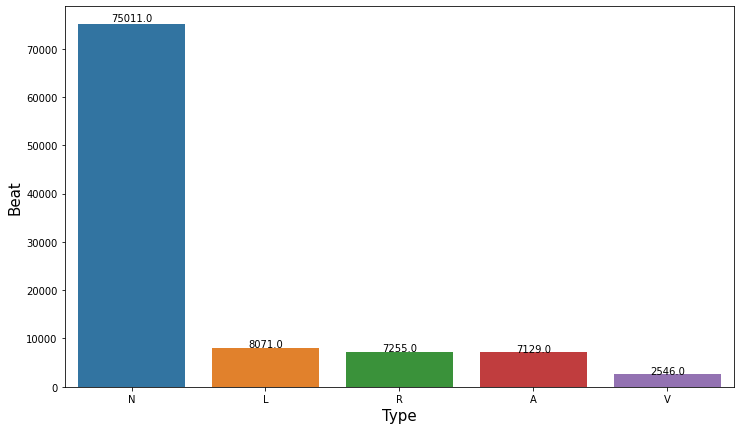

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1] - 1].value_counts()
plt.figure(figsize=(12,7))
ax = sns.barplot(x=['N', 'L', 'R', 'A', 'V'], y=per_class)
plt.xlabel("Type", fontsize=15)
plt.ylabel("Beat", fontsize=15)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x()
    y = p.get_y()
    ax.annotate(f"{height}", (x + width/2, y+ height*1.01), ha="center")
plt.show()

In [ ]:
df_0 = (X_train_df[X_train_df[X_train_df.shape[1]-1] == 0]).sample(n = 5000, random_state = 42)
df_1 = X_train_df[X_train_df[X_train_df.shape[1]-1] == 1]
df_2 = X_train_df[X_train_df[X_train_df.shape[1]-1] == 2]
df_3 = X_train_df[X_train_df[X_train_df.shape[1]-1] == 3]
df_4 = X_train_df[X_train_df[X_train_df.shape[1]-1] == 4]

df_1_upsample = resample(df_1, replace = True, n_samples = 5000, random_state = 122)
df_2_upsample = resample(df_2, replace = True, n_samples = 5000, random_state = 123)
df_3_upsample = resample(df_3, replace = True, n_samples = 5000, random_state = 124)
df_4_upsample = resample(df_4, replace = True, n_samples = 5000, random_state = 125)

X_train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

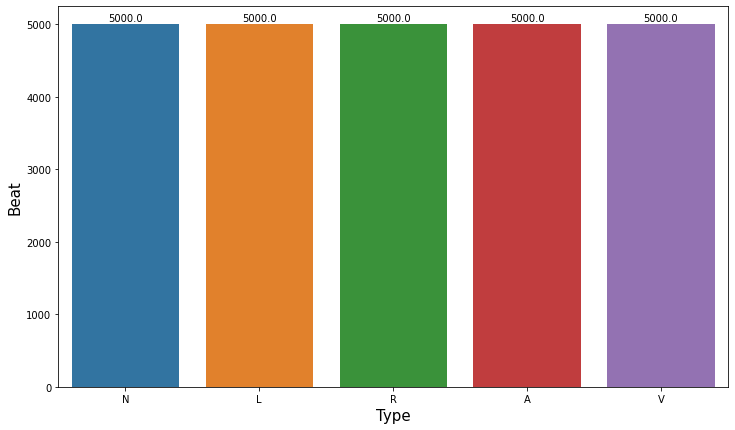

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
plt.figure(figsize=(12,7))
ax = sns.barplot(x=['N', 'L', 'R', 'A', 'V'], y=per_class)
plt.xlabel("Type", fontsize=15)
plt.ylabel("Beat", fontsize=15)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x()
    y = p.get_y()
    ax.annotate(f"{height}", (x + width/2, y+ height*1.01), ha="center")
plt.show()

In [ ]:
X = X_train_df.loc[:, :359]
Y = X_train_df[360]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

print("X_train : ", np.shape(x_train))
print("X_test  : ", np.shape(x_test))

X_train :  (17500, 360)
X_test  :  (7500, 360)


In [ ]:
# Metode yang akan dibandingkan
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

# Variabel Accuracy List
accuracy_list = []

In [ ]:
# Model KNeighborsClassifier Library
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
knn_prediction = knn_model.predict(x_test)
knn_accuracy = (round(accuracy_score(knn_prediction, y_test), 4) * 100) #percentage
accuracy_list.append(knn_accuracy)

In [ ]:
# Model Decison Tree Library
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
dt_prediction = dt_model.predict(x_test)
dt_accuracy = (round(accuracy_score(dt_prediction, y_test), 4) * 100) #percentage
accuracy_list.append(dt_accuracy)

In [ ]:
# Model Naive Bayes Library
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
nb_prediction = nb_model.predict(x_test)
nb_accuracy = (round(accuracy_score(nb_prediction, y_test), 4) * 100) #percentage
accuracy_list.append(nb_accuracy)

In [ ]:
# Model Random Forest Library
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
rf_prediction = rf_model.predict(x_test)
rf_accuracy = (round(accuracy_score(rf_prediction, y_test), 4) * 100) #percentage
accuracy_list.append(rf_accuracy)

In [ ]:
# Model Support Vector Machine Library
svc_model = SVC()
svc_model.fit(x_train, y_train)
svc_prediction = svc_model.predict(x_test)
svc_accuracy = (round(accuracy_score(svc_prediction, y_test), 4) * 100) #percentage
accuracy_list.append(svc_accuracy)

In [ ]:
models = ["KNeighborsClassifier", "Decision Tree", "Naive Bayes", "Random Forest", "SVC"]

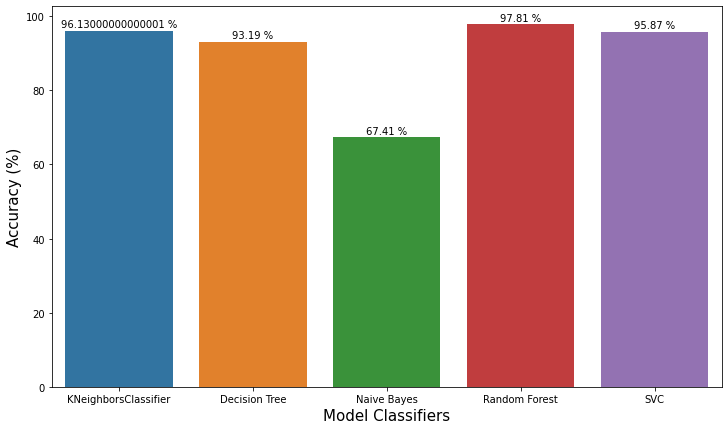

In [ ]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x=models, y=accuracy_list)
plt.xlabel("Model Classifiers", fontsize=15)
plt.ylabel("Accuracy (%)", fontsize=15)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x()
    y = p.get_y()
    ax.annotate(f"{height} %", (x + width/2, y+ height*1.01), ha="center")
plt.show()